In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob

In [2]:
import os
import pickle

In [11]:
from train import NN_lightning, DatasetVehicleSeq

In [11]:
all_csvs = glob.glob('data/s_nfs_model_for_ml/*.csv')

In [12]:
all_csvs

['data/s_nfs_model_for_ml\\learning_case_cars_100_hdv_0_av_30_hdv_def_70.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_100_hdv_10_av_30_hdv_def_60.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_100_hdv_20_av_30_hdv_def_50.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_100_hdv_30_av_30_hdv_def_40.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_100_hdv_40_av_30_hdv_def_30.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_100_hdv_50_av_30_hdv_def_20.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_100_hdv_60_av_30_hdv_def_10.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_100_hdv_70_av_30_hdv_def_0.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_200_hdv_0_av_30_hdv_def_70.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_200_hdv_10_av_30_hdv_def_60.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_200_hdv_20_av_30_hdv_def_50.csv',
 'data/s_nfs_model_for_ml\\learning_case_cars_200_hdv_30_av_30_hdv_def_40.csv',
 'data/s_nfs_model_for_ml\\learning_case_ca

In [13]:
best_model_path = 'lightning_logs_new/seq_len_48/version_0/checkpoints/epoch=113-step=113.ckpt'
hparams_file = 'lightning_logs_new/seq_len_48/version_0/hparams.yaml'
kw = dict(
        n_features=55, 
        fc_size=256,
        fc_layers=2,
        hidden_size=128,
        seq_len=32,
        batch_size=2048,
        num_layers=2,
        dropout=0.1,
        learning_rate=0.003,
        num_workers=8,

        # pin_mem=False
    )

In [14]:
nn = NN_lightning.load_from_checkpoint(best_model_path, hparams_file=hparams_file, **kw)

In [15]:
nn.eval()
nn.freeze()

In [16]:
nn.device

device(type='cuda', index=0)

In [17]:
# from makedb2 import clean_vehicle_ids, extract_step, npwindow, one_file2dict

In [18]:
# fname = all_csvs[33]
# width_forward, width_back = 13, 13
# fname

In [19]:
# df = pd.read_csv(fname)
# df = clean_vehicle_ids(df)
# df

In [20]:
# df['vehicle_id'].max(), df['pos_x'].max()

In [21]:
# def extract_meta(fname):
#     base = os.path.basename(fname)
#     pure = base.split('.')[0]
#     lst = pure.split('_')
#     cars = int(lst[lst.index('cars') + 1])
#     hdv = float(lst[lst.index('hdv') + 1])
#     av = float(lst[lst.index('av') + 1])
#     hdv_def = float(lst[lst.index('def') + 1])
#     return cars, hdv, av, hdv_def

# extract_meta(fname)

In [22]:
# one_scenario_dict = one_file2dict((fname, width_forward, width_back))

In [23]:
# one_scenario_dict['meta'] = extract_meta(fname)

In [24]:
import pickle

In [5]:
db_path = r'Z:\traffic\src\data\tempz.bin'
# with open(db_path, 'wb') as f:
#     pickle.dump(one_scenario_dict, f)

In [6]:
with open(db_path, 'rb') as f:
    one_scenario_dict = pickle.load(f)

In [7]:
one_scenario_dict.keys()

dict_keys(['AV', 'HDV', 'HDV_DEF', 'meta'])

In [8]:
ds = DatasetVehicleSeq(48, db_path=db_path, allow_cache=False)

In [9]:
len(ds)

570847

In [10]:
ds[77]

(tensor([[1., 2., 2.,  ..., 0., 0., 0.],
         [1., 2., 2.,  ..., 0., 0., 0.],
         [1., 0., 2.,  ..., 2., 0., 0.],
         ...,
         [1., 0., 2.,  ..., 3., 3., 0.],
         [1., 0., 0.,  ..., 2., 2., 0.],
         [1., 0., 0.,  ..., 0., 3., 0.]]),
 tensor(1))

In [28]:
X, Y = ds[2]
X, Y

(tensor([[0., 3., 0.,  ..., 1., 1., 0.],
         [0., 2., 0.,  ..., 0., 2., 0.],
         [0., 0., 0.,  ..., 0., 3., 0.],
         ...,
         [0., 2., 2.,  ..., 0., 1., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]]),
 tensor(1))

In [29]:
import torch as T

In [45]:
label_list = ['AV', 'HDV', 'HDV_DEF']

In [46]:
batch = X[None, :, :].clone().detach().to(nn.device)
y_pred_softmax = nn.forward(batch).cpu().detach().numpy()
pred = np.argmax(np.exp(y_pred_softmax))
label_list[pred], label_list[Y.item()]

('HDV', 'HDV')

In [58]:
X, Y = ds[-99]
for i in range(1,49):
    batch = X[None, :i, :].clone().detach().to(nn.device)
    y_pred_softmax = nn.forward(batch).cpu().detach().numpy()
    pred = np.argmax(np.exp(y_pred_softmax))
    y_pred, y_true = label_list[pred], label_list[Y.item()]
    print(i, int(y_pred==y_true), y_pred, y_true)

1 0 HDV_DEF AV
2 0 HDV_DEF AV
3 0 HDV_DEF AV
4 0 HDV_DEF AV
5 0 HDV_DEF AV
6 0 HDV_DEF AV
7 0 HDV AV
8 0 HDV AV
9 0 HDV AV
10 0 HDV AV
11 0 HDV AV
12 0 HDV AV
13 0 HDV AV
14 1 AV AV
15 1 AV AV
16 1 AV AV
17 1 AV AV
18 1 AV AV
19 1 AV AV
20 1 AV AV
21 1 AV AV
22 1 AV AV
23 1 AV AV
24 1 AV AV
25 1 AV AV
26 1 AV AV
27 1 AV AV
28 1 AV AV
29 1 AV AV
30 1 AV AV
31 1 AV AV
32 1 AV AV
33 1 AV AV
34 1 AV AV
35 1 AV AV
36 1 AV AV
37 1 AV AV
38 1 AV AV
39 1 AV AV
40 1 AV AV
41 1 AV AV
42 1 AV AV
43 1 AV AV
44 1 AV AV
45 1 AV AV
46 1 AV AV
47 1 AV AV
48 1 AV AV


In [3]:
from tqdm import tqdm

In [65]:
res = {}
res['meta'] = one_scenario_dict['meta']
res['chunks'] = []
for k in tqdm(range(0, len(ds), 24)):
    X, Y = ds[k]
    chunk = []
    for i in range(1,49):
        batch = X[None, :i, :].clone().detach().to(nn.device)
        y_pred_softmax = nn.forward(batch).cpu().detach().numpy()
        pred = np.argmax(np.exp(y_pred_softmax))
        y_pred, y_true = label_list[pred], label_list[Y.item()]
        chunk.append((i, int(y_pred==y_true), pred, Y.item()))
    res['chunks'].append(np.array(chunk, dtype=np.int8))
    
# res

 27%|███████████████████████████████████████▋                                                                                                             | 6343/23786 [04:24<12:07, 23.98it/s]


KeyboardInterrupt: 

In [71]:
megares = {}

In [72]:
for fname in glob.glob(r'Z:\traffic\src\data\bins\*'):
    basename = os.path.basename(fname)
    print(basename)
    if basename in megares:
        continue
    
    with open(fname, 'rb') as f:
        one_scenario_dict = pickle.load(f)
        
    ds = DatasetVehicleSeq(48, db_path=fname, allow_cache=False)
    res = {}
    res['meta'] = one_scenario_dict['meta']
    res['chunks'] = []
    for k in tqdm(range(0, len(ds), 48)):
        X, Y = ds[k]
        chunk = []
        for i in range(1,49):
            batch = X[None, :i, :].clone().detach().to(nn.device)
            y_pred_softmax = nn.forward(batch).cpu().detach().numpy()
            pred = np.argmax(np.exp(y_pred_softmax))
            y_pred, y_true = label_list[pred], label_list[Y.item()]
            chunk.append((i, int(y_pred==y_true), pred, Y.item()))
        res['chunks'].append(np.array(chunk, dtype=np.int8))
    megares[basename] = res

learning_case_cars_100_hdv_0_av_30_hdv_def_70.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [01:25<00:00, 23.20it/s]


learning_case_cars_100_hdv_10_av_30_hdv_def_60.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1966/1966 [01:24<00:00, 23.27it/s]


learning_case_cars_100_hdv_20_av_30_hdv_def_50.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1966/1966 [01:24<00:00, 23.24it/s]


learning_case_cars_100_hdv_30_av_30_hdv_def_40.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [01:25<00:00, 23.25it/s]


learning_case_cars_100_hdv_40_av_30_hdv_def_30.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [01:25<00:00, 23.24it/s]


learning_case_cars_100_hdv_50_av_30_hdv_def_20.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [01:25<00:00, 23.28it/s]


learning_case_cars_100_hdv_60_av_30_hdv_def_10.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [01:25<00:00, 23.27it/s]


learning_case_cars_100_hdv_70_av_30_hdv_def_0.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [01:25<00:00, 23.27it/s]


learning_case_cars_200_hdv_0_av_30_hdv_def_70.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:49<00:00, 23.40it/s]


learning_case_cars_200_hdv_10_av_30_hdv_def_60.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3951/3951 [02:48<00:00, 23.41it/s]


learning_case_cars_200_hdv_20_av_30_hdv_def_50.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3951/3951 [02:48<00:00, 23.50it/s]


learning_case_cars_200_hdv_30_av_30_hdv_def_40.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:45<00:00, 24.00it/s]


learning_case_cars_200_hdv_40_av_30_hdv_def_30.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:44<00:00, 24.07it/s]


learning_case_cars_200_hdv_50_av_30_hdv_def_20.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:44<00:00, 24.10it/s]


learning_case_cars_200_hdv_60_av_30_hdv_def_10.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:44<00:00, 24.07it/s]


learning_case_cars_200_hdv_70_av_30_hdv_def_0.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:45<00:00, 24.02it/s]


learning_case_cars_300_hdv_0_av_30_hdv_def_70.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5957/5957 [04:05<00:00, 24.26it/s]


learning_case_cars_300_hdv_10_av_30_hdv_def_60.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [04:04<00:00, 24.26it/s]


learning_case_cars_300_hdv_20_av_30_hdv_def_50.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [04:04<00:00, 24.26it/s]


learning_case_cars_300_hdv_30_av_30_hdv_def_40.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [04:04<00:00, 24.32it/s]


learning_case_cars_300_hdv_40_av_30_hdv_def_30.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [04:04<00:00, 24.31it/s]


learning_case_cars_300_hdv_50_av_30_hdv_def_20.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [04:04<00:00, 24.29it/s]


learning_case_cars_300_hdv_60_av_30_hdv_def_10.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [04:04<00:00, 24.28it/s]


learning_case_cars_300_hdv_70_av_30_hdv_def_0.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5957/5957 [04:05<00:00, 24.27it/s]


learning_case_cars_400_hdv_0_av_30_hdv_def_70.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [05:27<00:00, 24.29it/s]


learning_case_cars_400_hdv_10_av_30_hdv_def_60.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7922/7922 [05:27<00:00, 24.19it/s]


learning_case_cars_400_hdv_20_av_30_hdv_def_50.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7922/7922 [05:26<00:00, 24.27it/s]


learning_case_cars_400_hdv_30_av_30_hdv_def_40.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [05:26<00:00, 24.31it/s]


learning_case_cars_400_hdv_40_av_30_hdv_def_30.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [05:25<00:00, 24.36it/s]


learning_case_cars_400_hdv_50_av_30_hdv_def_20.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [05:26<00:00, 24.31it/s]


learning_case_cars_400_hdv_60_av_30_hdv_def_10.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [05:30<00:00, 24.05it/s]


learning_case_cars_400_hdv_70_av_30_hdv_def_0.bin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [05:29<00:00, 24.09it/s]


learning_case_cars_600_hdv_0_av_30_hdv_def_70.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11913/11913 [08:16<00:00, 24.00it/s]


learning_case_cars_600_hdv_10_av_30_hdv_def_60.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [08:15<00:00, 24.00it/s]


learning_case_cars_600_hdv_20_av_30_hdv_def_50.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [08:15<00:00, 23.98it/s]


learning_case_cars_600_hdv_30_av_30_hdv_def_40.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [08:17<00:00, 23.93it/s]


learning_case_cars_600_hdv_40_av_30_hdv_def_30.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [08:16<00:00, 23.94it/s]


learning_case_cars_600_hdv_50_av_30_hdv_def_20.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [08:16<00:00, 23.96it/s]


learning_case_cars_600_hdv_60_av_30_hdv_def_10.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [08:19<00:00, 23.82it/s]


learning_case_cars_600_hdv_70_av_30_hdv_def_0.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11913/11913 [08:17<00:00, 23.96it/s]


learning_case_cars_800_hdv_0_av_30_hdv_def_70.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [10:58<00:00, 24.13it/s]


learning_case_cars_800_hdv_10_av_30_hdv_def_60.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15864/15864 [11:02<00:00, 23.94it/s]


learning_case_cars_800_hdv_20_av_30_hdv_def_50.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15864/15864 [11:08<00:00, 23.75it/s]


learning_case_cars_800_hdv_30_av_30_hdv_def_40.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [11:09<00:00, 23.72it/s]


learning_case_cars_800_hdv_40_av_30_hdv_def_30.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [11:10<00:00, 23.70it/s]


learning_case_cars_800_hdv_50_av_30_hdv_def_20.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [11:08<00:00, 23.75it/s]


learning_case_cars_800_hdv_60_av_30_hdv_def_10.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [11:00<00:00, 24.06it/s]


learning_case_cars_800_hdv_70_av_30_hdv_def_0.bin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [11:02<00:00, 23.99it/s]


In [73]:
# with open(r'Z:\traffic\src\data\megares_with_meta.bin', 'wb') as f:
#     pickle.dump(megares, f)

In [3]:
with open(r'Z:\traffic\src\data\megares_with_meta.bin', 'rb') as f:
    megares = pickle.load(f)

In [6]:
megares.keys()

dict_keys(['learning_case_cars_100_hdv_0_av_30_hdv_def_70.bin', 'learning_case_cars_100_hdv_10_av_30_hdv_def_60.bin', 'learning_case_cars_100_hdv_20_av_30_hdv_def_50.bin', 'learning_case_cars_100_hdv_30_av_30_hdv_def_40.bin', 'learning_case_cars_100_hdv_40_av_30_hdv_def_30.bin', 'learning_case_cars_100_hdv_50_av_30_hdv_def_20.bin', 'learning_case_cars_100_hdv_60_av_30_hdv_def_10.bin', 'learning_case_cars_100_hdv_70_av_30_hdv_def_0.bin', 'learning_case_cars_200_hdv_0_av_30_hdv_def_70.bin', 'learning_case_cars_200_hdv_10_av_30_hdv_def_60.bin', 'learning_case_cars_200_hdv_20_av_30_hdv_def_50.bin', 'learning_case_cars_200_hdv_30_av_30_hdv_def_40.bin', 'learning_case_cars_200_hdv_40_av_30_hdv_def_30.bin', 'learning_case_cars_200_hdv_50_av_30_hdv_def_20.bin', 'learning_case_cars_200_hdv_60_av_30_hdv_def_10.bin', 'learning_case_cars_200_hdv_70_av_30_hdv_def_0.bin', 'learning_case_cars_300_hdv_0_av_30_hdv_def_70.bin', 'learning_case_cars_300_hdv_10_av_30_hdv_def_60.bin', 'learning_case_cars_30

In [4]:
import matplotlib.pyplot as plt

In [5]:
res = megares['learning_case_cars_100_hdv_10_av_30_hdv_def_60.bin']

In [6]:
res.keys()

dict_keys(['meta', 'chunks'])

In [8]:
cars, hdv, av, hdv_def = res['meta']
cars, hdv, av, hdv_def

(100, 10.0, 30.0, 60.0)

In [9]:
chunks = res['chunks']
len(chunks)

1966

In [14]:
chunks[0]

array([[ 1,  0,  2,  1],
       [ 2,  0,  2,  1],
       [ 3,  0,  2,  1],
       [ 4,  0,  2,  1],
       [ 5,  0,  2,  1],
       [ 6,  0,  2,  1],
       [ 7,  0,  2,  1],
       [ 8,  0,  2,  1],
       [ 9,  0,  2,  1],
       [10,  0,  2,  1],
       [11,  0,  2,  1],
       [12,  0,  2,  1],
       [13,  0,  2,  1],
       [14,  0,  2,  1],
       [15,  0,  2,  1],
       [16,  0,  2,  1],
       [17,  0,  2,  1],
       [18,  0,  2,  1],
       [19,  1,  1,  1],
       [20,  1,  1,  1],
       [21,  1,  1,  1],
       [22,  1,  1,  1],
       [23,  1,  1,  1],
       [24,  1,  1,  1],
       [25,  1,  1,  1],
       [26,  1,  1,  1],
       [27,  1,  1,  1],
       [28,  1,  1,  1],
       [29,  1,  1,  1],
       [30,  1,  1,  1],
       [31,  1,  1,  1],
       [32,  1,  1,  1],
       [33,  1,  1,  1],
       [34,  1,  1,  1],
       [35,  1,  1,  1],
       [36,  1,  1,  1],
       [37,  1,  1,  1],
       [38,  1,  1,  1],
       [39,  1,  1,  1],
       [40,  1,  1,  1],


In [67]:
def chunk2steps(chunk):
    sucrow = chunk[:, 1]
    chunk[sucrow == 0, -1]
    steps = chunk.shape[0] - np.sum(chunk[:, 1])
    # steps = chunk[sucrow == 0, 0]
    # if len(steps) == 0:
    #     steps = 1
    # else:
    #     steps = steps[-1]
    label = chunk[0, -1]
    return steps, label 

chunk2steps(chunks[0])

(18, 1)

In [103]:
# ['AV', 'HDV', 'HDV_DEF']
labels = ['AV', 'HDV', 'DHDV']
stats = {
    'AV': [],
    'HDV': [],
    'DHDV': []
}
for chunk in chunks:
    steps, ilabel = chunk2steps(chunk)
    stats[labels[ilabel]].append(steps)
for k in stats:
    print(k, np.average(stats[k]))

AV 16.354459601259183
HDV 19.69008004316935
DHDV nan


C:\Users\Mikhail\.conda\envs\env_swrm\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Mikhail\.conda\envs\env_swrm\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [87]:
points = {
    'AV': [],
    'HDV': [],
    'DHDV': []
}
pointsall = {
    'AV': [],
    'HDV': [],
    'DHDV': []
}
for res in megares.values():
    chunks = res['chunks']
    cars, hdv, av, hdv_def = res['meta']
    labels = ['AV', 'HDV', 'DHDV']
    stats = {
        'AV': [],
        'HDV': [],
        'DHDV': []
    }
    for chunk in chunks:
        steps, ilabel = chunk2steps(chunk)
        stats[labels[ilabel]].append(steps)
    for k in stats:
        if len(stats[k]) == 0:
            continue
        avg = np.average(stats[k])
        points[k].append((cars, hdv_def, avg, avg + 3*np.std(stats[k])))
        pointsall[k].extend(stats[k])

In [73]:
import seaborn as sns
sns.set_style("white")

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_37452\1896052130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pointsall[k], bins=24, label=k, color=col, ax=ax)
C:\Users\Mikhail\AppData\Local\Temp\ipykernel_37452\1896052130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pointsall[k], bi

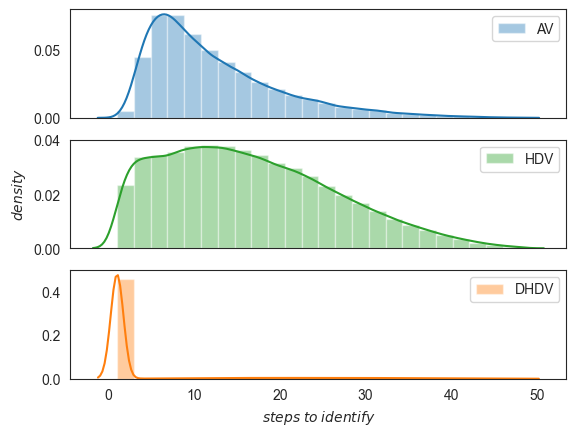

In [106]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
for k, ax, col in zip(pointsall, (ax1, ax2, ax3), ('C0', 'C2', 'C1')):
    # ax.hist(pointsall[k], density=True, bins=25, label=k, color=col)
    sns.distplot(pointsall[k], bins=24, label=k, color=col, ax=ax)
    ax.set_ylabel('')
    ax.legend()
ax2.set_ylabel('$density$')
ax3.set_xlabel('$steps$ $to$ $identify$')
plt.savefig('Z:\\traffic\\stuff\\hist.png', dpi=300)

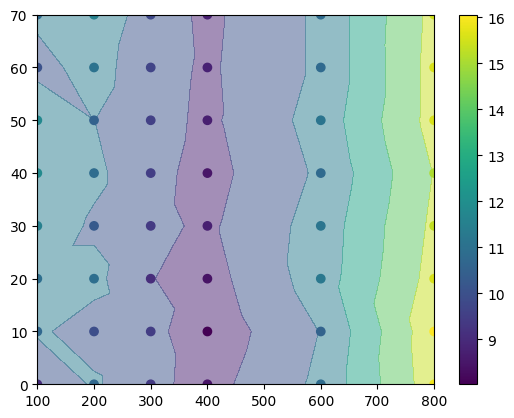

In [89]:
arr = np.array(points['AV'])

plt.tricontourf(arr[:, 0], arr[:, 1], arr[:,2], alpha=0.5)

plt.scatter(arr[:, 0], arr[:, 1], c=arr[:,2])
plt.colorbar()


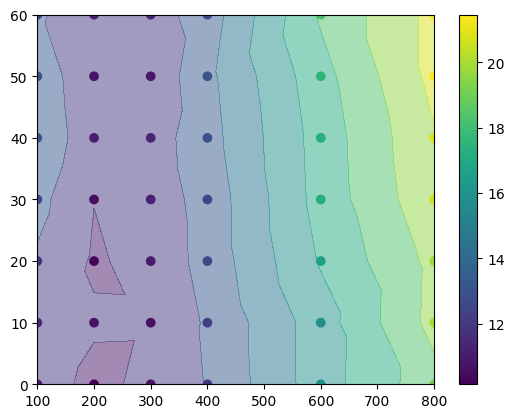

In [90]:
arr = np.array(points['HDV'])

plt.tricontourf(arr[:, 0], arr[:, 1], arr[:,2], alpha=0.5)

plt.scatter(arr[:, 0], arr[:, 1], c=arr[:,2])
plt.colorbar()

In [112]:
def false_dict(chunk):
    sucrow = chunk[:, 1]
    false_i = sucrow == 0
    false_chunk = chunk[false_i]
    if len(false_chunk) == 0:
        return None
    return false_chunk[:, [0,2]]
false_dict(chunk)

array([[ 1,  2],
       [ 2,  2],
       [ 3,  2],
       [ 4,  2],
       [ 5,  2],
       [ 6,  2],
       [ 7,  2],
       [ 8,  2],
       [ 9,  2],
       [10,  2],
       [11,  2],
       [12,  2],
       [13,  2],
       [14,  2],
       [15,  2],
       [16,  2],
       [17,  1],
       [18,  1],
       [19,  1],
       [20,  1],
       [21,  1],
       [22,  2],
       [23,  2],
       [24,  2],
       [25,  1],
       [26,  1],
       [27,  1],
       [28,  1],
       [29,  1],
       [30,  1],
       [31,  1],
       [32,  1]], dtype=int8)

In [115]:
from collections import Counter

In [157]:
falsestats = {i: Counter() for i in range(1,49)}
for res in megares.values():
    chunks = res['chunks']
    for chunk in chunks:
        fd = false_dict(chunk)
        for k in falsestats:
            falsestats[k]['all'] += 1
        if fd is None:
            continue
        for step, false_label in fd:
            falsestats[step][labels[false_label]] += 1


In [158]:
falsestats

{1: Counter({'all': 380824, 'DHDV': 247430, 'HDV': 99}),
 2: Counter({'all': 380824, 'DHDV': 242965, 'HDV': 2049, 'AV': 10}),
 3: Counter({'all': 380824, 'DHDV': 234427, 'HDV': 4958, 'AV': 63}),
 4: Counter({'all': 380824, 'DHDV': 223184, 'HDV': 7316, 'AV': 153}),
 5: Counter({'all': 380824, 'DHDV': 209616, 'HDV': 9087, 'AV': 362}),
 6: Counter({'all': 380824, 'DHDV': 194810, 'HDV': 10211, 'AV': 545}),
 7: Counter({'all': 380824, 'DHDV': 180222, 'HDV': 10704, 'AV': 730}),
 8: Counter({'all': 380824, 'DHDV': 166219, 'HDV': 10840, 'AV': 950}),
 9: Counter({'all': 380824, 'DHDV': 152929, 'HDV': 10850, 'AV': 1103}),
 10: Counter({'all': 380824, 'DHDV': 140822, 'HDV': 10555, 'AV': 1245}),
 11: Counter({'all': 380824, 'DHDV': 129408, 'HDV': 10415, 'AV': 1343}),
 12: Counter({'all': 380824, 'DHDV': 118913, 'HDV': 10165, 'AV': 1420}),
 13: Counter({'all': 380824, 'DHDV': 109133, 'HDV': 9931, 'AV': 1448}),
 14: Counter({'all': 380824, 'DHDV': 99613, 'HDV': 9739, 'AV': 1461}),
 15: Counter({'all

In [140]:
list(falsestats[2].values())

[2049, 242965, 10]

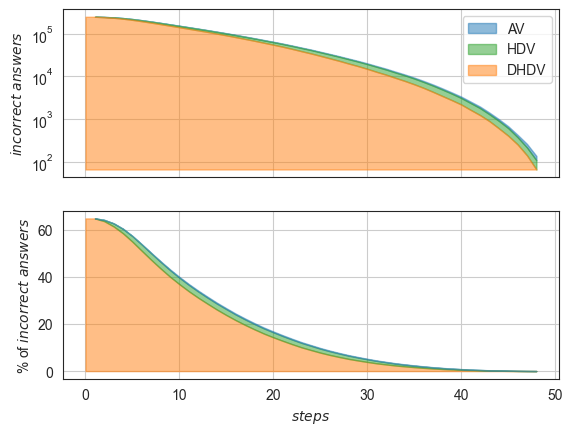

In [162]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

xs = list(falsestats.keys())
k = 'DHDV'
ys = np.array( [falsestats[x][k] for x in xs])


k = 'HDV'
ys1 = np.array([falsestats[x][k] for x in xs])


k = 'AV'
ys2 = np.array([falsestats[x][k] for x in xs])
ax1.fill_between(xs, ys+ys1, ys+ys1+ys2, color='C0', alpha=0.5, label=k)
ax1.fill_between(xs, ys, ys+ys1, color='C2', alpha=0.5, label='HDV')
ax1.fill_betweenx(ys, xs, color='C1', alpha=0.5, label='DHDV')

ax1.set_yscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('$incorrect$ $answers$')

N = np.array([falsestats[x]['all'] for x in xs]) /100

xs = list(falsestats.keys())
k = 'DHDV'
ax2.fill_betweenx(ys/N, xs, color='C1', alpha=0.5)

k = 'HDV'
ax2.fill_between(xs, ys/N, (ys+ys1)/N, color='C2', alpha=0.5)

k = 'AV'
ax2.fill_between(xs, (ys+ys1)/N, (ys+ys1+ys2)/N, color='C0', alpha=0.5)

ax2.grid()
ax2.set_ylabel('% of $incorrect$ $answers$')

ax2.set_xlabel('$steps$')
# ax2.set_yscale('log')

plt.savefig('Z:\\traffic\\stuff\\wrong.png', dpi=300)

In [17]:
arr = np.array(points['AV'])
arr

array([[100.        ,  70.        ,  10.76510067],
       [100.        ,  60.        ,  10.04194631],
       [100.        ,  50.        ,  11.76006711],
       [100.        ,  40.        ,  11.83724832],
       [100.        ,  30.        ,  11.49161074],
       [100.        ,  20.        ,  10.88758389],
       [100.        ,  10.        ,  10.70637584],
       [100.        ,   0.        ,   9.08221477],
       [200.        ,  70.        ,  11.51469353],
       [200.        ,  60.        ,  11.03862301],
       [200.        ,  50.        ,  10.51469353],
       [200.        ,  40.        ,  10.83123426],
       [200.        ,  30.        ,  10.26532326],
       [200.        ,  20.        ,  10.9093199 ],
       [200.        ,  10.        ,   9.90764064],
       [200.        ,   0.        ,  10.697733  ],
       [300.        ,  70.        ,   9.80470062],
       [300.        ,  60.        ,   9.6530498 ],
       [300.        ,  50.        ,   9.54840515],
       [300.        ,  40.     

In [95]:
megares2 = {}

In [92]:
X

tensor([[ 1.,  0.,  3.,  ...,  1.,  1.,  0.],
        [ 1., -1.,  0.,  ...,  1.,  1.,  0.],
        [ 1.,  2.,  0.,  ...,  1.,  1.,  0.],
        ...,
        [ 0.,  2.,  1.,  ...,  2.,  2.,  0.],
        [ 0.,  1.,  0.,  ...,  1.,  1.,  0.],
        [ 0.,  0.,  2.,  ...,  1.,  1.,  0.]])

In [96]:
# пробуем достать скорости
for fname in glob.glob(r'Z:\traffic\src\data\bins\*'):
    basename = os.path.basename(fname)
    print(basename)
    if basename in megares2:
        continue
    
    with open(fname, 'rb') as f:
        one_scenario_dict = pickle.load(f)
    ds = DatasetVehicleSeq(48, db_path=fname, allow_cache=False)
    res = {}
    res['meta'] = one_scenario_dict['meta']
    res['chunks'] = []
    for k in tqdm(range(0, len(ds), 48)):
        X, Y = ds[k]
        chunk = []
        for i in range(1,49):
            Mflat = np.abs(X[i-1, 1:].clone().detach().numpy())
            V_avg = np.average(Mflat[Mflat > 0] - 1)
            TS_count = np.sum(Mflat > 0.001)
            V_sum = np.sum(Mflat[Mflat > 0] - 1)
            # номер, средняя скорость, плотность потока, поток
            chunk.append((i, V_avg, TS_count/54, V_sum))
        res['chunks'].append(np.array(chunk))
    megares2[basename] = res

learning_case_cars_100_hdv_0_av_30_hdv_def_70.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [00:05<00:00, 387.96it/s]


learning_case_cars_100_hdv_10_av_30_hdv_def_60.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1966/1966 [00:05<00:00, 389.20it/s]


learning_case_cars_100_hdv_20_av_30_hdv_def_50.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1966/1966 [00:05<00:00, 387.01it/s]


learning_case_cars_100_hdv_30_av_30_hdv_def_40.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [00:05<00:00, 389.57it/s]


learning_case_cars_100_hdv_40_av_30_hdv_def_30.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [00:05<00:00, 389.46it/s]


learning_case_cars_100_hdv_50_av_30_hdv_def_20.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [00:05<00:00, 386.65it/s]


learning_case_cars_100_hdv_60_av_30_hdv_def_10.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [00:05<00:00, 386.76it/s]


learning_case_cars_100_hdv_70_av_30_hdv_def_0.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1986/1986 [00:05<00:00, 389.75it/s]


learning_case_cars_200_hdv_0_av_30_hdv_def_70.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:10<00:00, 384.67it/s]


learning_case_cars_200_hdv_10_av_30_hdv_def_60.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3951/3951 [00:10<00:00, 386.76it/s]


learning_case_cars_200_hdv_20_av_30_hdv_def_50.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3951/3951 [00:10<00:00, 385.83it/s]


learning_case_cars_200_hdv_30_av_30_hdv_def_40.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:10<00:00, 388.04it/s]


learning_case_cars_200_hdv_40_av_30_hdv_def_30.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:10<00:00, 389.19it/s]


learning_case_cars_200_hdv_50_av_30_hdv_def_20.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:10<00:00, 387.37it/s]


learning_case_cars_200_hdv_60_av_30_hdv_def_10.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:10<00:00, 388.54it/s]


learning_case_cars_200_hdv_70_av_30_hdv_def_0.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:10<00:00, 387.12it/s]


learning_case_cars_300_hdv_0_av_30_hdv_def_70.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5957/5957 [00:15<00:00, 387.28it/s]


learning_case_cars_300_hdv_10_av_30_hdv_def_60.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [00:15<00:00, 387.21it/s]


learning_case_cars_300_hdv_20_av_30_hdv_def_50.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [00:15<00:00, 387.49it/s]


learning_case_cars_300_hdv_30_av_30_hdv_def_40.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [00:15<00:00, 387.66it/s]


learning_case_cars_300_hdv_40_av_30_hdv_def_30.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [00:15<00:00, 387.16it/s]


learning_case_cars_300_hdv_50_av_30_hdv_def_20.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [00:15<00:00, 387.82it/s]


learning_case_cars_300_hdv_60_av_30_hdv_def_10.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5937/5937 [00:15<00:00, 388.42it/s]


learning_case_cars_300_hdv_70_av_30_hdv_def_0.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5957/5957 [00:15<00:00, 387.85it/s]


learning_case_cars_400_hdv_0_av_30_hdv_def_70.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [00:20<00:00, 387.43it/s]


learning_case_cars_400_hdv_10_av_30_hdv_def_60.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7922/7922 [00:20<00:00, 386.76it/s]


learning_case_cars_400_hdv_20_av_30_hdv_def_50.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7922/7922 [00:20<00:00, 386.61it/s]


learning_case_cars_400_hdv_30_av_30_hdv_def_40.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [00:20<00:00, 386.86it/s]


learning_case_cars_400_hdv_40_av_30_hdv_def_30.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [00:20<00:00, 387.50it/s]


learning_case_cars_400_hdv_50_av_30_hdv_def_20.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [00:20<00:00, 387.41it/s]


learning_case_cars_400_hdv_60_av_30_hdv_def_10.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [00:20<00:00, 386.85it/s]


learning_case_cars_400_hdv_70_av_30_hdv_def_0.bin


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7942/7942 [00:20<00:00, 387.54it/s]


learning_case_cars_600_hdv_0_av_30_hdv_def_70.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11913/11913 [00:30<00:00, 386.88it/s]


learning_case_cars_600_hdv_10_av_30_hdv_def_60.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [00:30<00:00, 388.05it/s]


learning_case_cars_600_hdv_20_av_30_hdv_def_50.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [00:30<00:00, 387.92it/s]


learning_case_cars_600_hdv_30_av_30_hdv_def_40.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [00:30<00:00, 387.77it/s]


learning_case_cars_600_hdv_40_av_30_hdv_def_30.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [00:30<00:00, 386.90it/s]


learning_case_cars_600_hdv_50_av_30_hdv_def_20.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [00:30<00:00, 386.92it/s]


learning_case_cars_600_hdv_60_av_30_hdv_def_10.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11893/11893 [00:30<00:00, 387.43it/s]


learning_case_cars_600_hdv_70_av_30_hdv_def_0.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11913/11913 [00:30<00:00, 388.15it/s]


learning_case_cars_800_hdv_0_av_30_hdv_def_70.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [00:40<00:00, 387.82it/s]


learning_case_cars_800_hdv_10_av_30_hdv_def_60.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15864/15864 [00:40<00:00, 388.94it/s]


learning_case_cars_800_hdv_20_av_30_hdv_def_50.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15864/15864 [00:40<00:00, 388.04it/s]


learning_case_cars_800_hdv_30_av_30_hdv_def_40.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [00:40<00:00, 388.52it/s]


learning_case_cars_800_hdv_40_av_30_hdv_def_30.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [00:40<00:00, 388.05it/s]


learning_case_cars_800_hdv_50_av_30_hdv_def_20.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [00:40<00:00, 387.84it/s]


learning_case_cars_800_hdv_60_av_30_hdv_def_10.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [00:40<00:00, 388.22it/s]


learning_case_cars_800_hdv_70_av_30_hdv_def_0.bin


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15884/15884 [00:40<00:00, 387.86it/s]


In [97]:
with open(r'Z:\traffic\src\data\megares2_with_meta.bin', 'wb') as f:
    pickle.dump(megares2, f)

In [6]:
with open(r'Z:\traffic\src\data\megares2_with_meta.bin', 'rb') as f:
    megares2 = pickle.load(f)

In [98]:
stats = {
    'AV': [],
    'HDV': [],
    'DHDV': []
}
stats2 = {
    'AV': [],
    'HDV': [],
    'DHDV': []
}
for name in megares:
    res = megares[name]
    res2 = megares2[name]
    chunks = res['chunks']
    chunks2 = res2['chunks']
    cars, hdv, av, hdv_def = res['meta']
    labels = ['AV', 'HDV', 'DHDV']

    for chunk, chunk2 in zip(chunks, chunks2):
        steps, ilabel = chunk2steps(chunk)
        stats[labels[ilabel]].append(steps)
        stats2[labels[ilabel]].append(np.hstack([np.average(chunk2, axis=0), steps]))
for k in stats2:
    stats2[k] = np.array(stats2[k]) 

In [26]:
# for k in stats2:
#     stats2[k] = np.array(stats2[k])

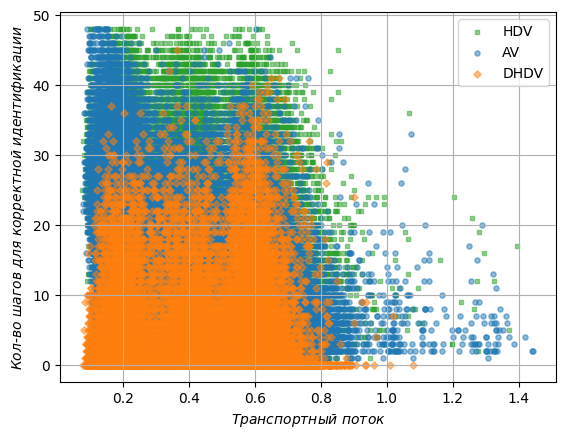

In [106]:
# номер, средняя скорость, плотность потока, поток


k = 'HDV'
arr = stats2[k]
plt.scatter(arr[:, 3]/27/2, arr[:, -1], c='C2', marker='s', s=10, alpha=0.5, label=k)

k = 'AV'
arr = stats2[k]
plt.scatter(arr[:, 3]/27/2, arr[:, -1], c='C0', marker='o', s=14, alpha=0.5, label=k)

k = 'DHDV'
arr = stats2[k]
plt.scatter(arr[:, 3]/27/2, arr[:, -1], c='C1', marker='D', s=14, alpha=0.5, label=k)

plt.grid()
plt.legend()
plt.xlabel('$Транспортный$ $поток$')
plt.ylabel('$Кол$-$во$ $шагов$ $для$ $корректной$ $идентификации$')
plt.savefig('Z:\\traffic\\stuff\\last.png', dpi=300)

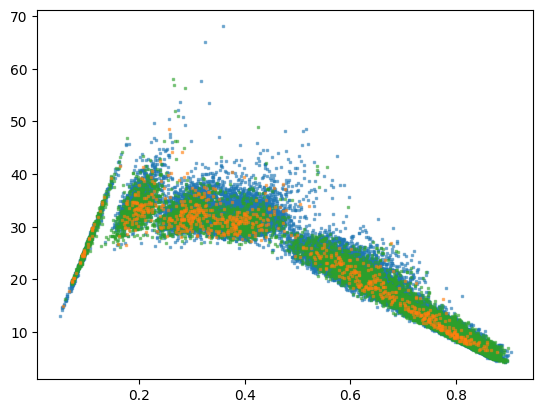

In [132]:
k = 'HDV'
arr = stats2[k]
ii = arr[:, -1] > 20
plt.scatter(arr[ii, 2], arr[ii, 3], marker='s', s=1, alpha=0.5)

k = 'DHDV'
arr = stats2[k]
ii = arr[:, -1] > 20
plt.scatter(arr[ii, 2], arr[ii, 3], marker='s', s=1, alpha=0.5, zorder=3)

k = 'AV'
arr = stats2[k]
ii = arr[:, -1] > 20
plt.scatter(arr[ii, 2], arr[ii, 3], marker='s', s=1, alpha=0.5)

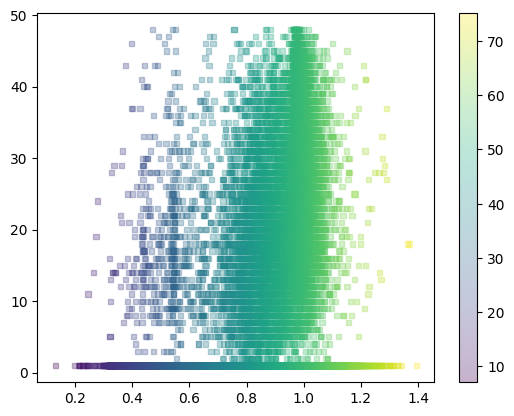

In [50]:
k = 'DHDV'
arr = stats2[k]
plt.scatter(arr[:, 1], arr[:, -1], c=arr[:, 3], marker='s', s=14, alpha=0.3)
plt.colorbar()

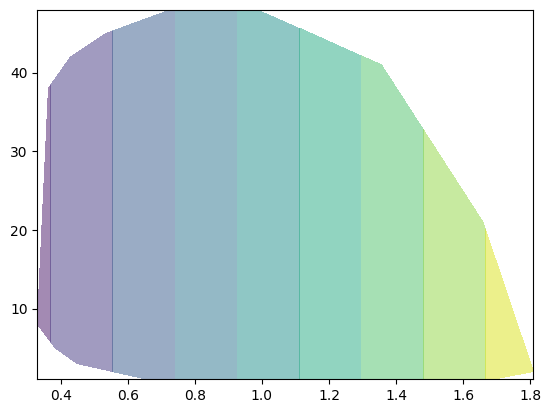

In [41]:
plt.tricontourf(arr[:, 1], arr[:, -1], arr[:, 3], alpha=0.5)

In [20]:
np.average(chunk2, axis=0)

array([24.5       ,  0.57947532,  0.10108025, 31.29166667])

In [16]:
chunk2

array([[ 1.        ,  0.66666669,  0.11111111, 36.        ],
       [ 2.        ,  0.66666669,  0.11111111, 36.        ],
       [ 3.        ,  0.66666669,  0.11111111, 36.        ],
       [ 4.        ,  0.66666669,  0.11111111, 36.        ],
       [ 5.        ,  0.64814812,  0.11111111, 35.        ],
       [ 6.        ,  0.6111111 ,  0.11111111, 33.        ],
       [ 7.        ,  0.53703701,  0.11111111, 29.        ],
       [ 8.        ,  0.53703701,  0.11111111, 29.        ],
       [ 9.        ,  0.62962961,  0.11111111, 34.        ],
       [10.        ,  0.66666669,  0.11111111, 36.        ],
       [11.        ,  0.6111111 ,  0.11111111, 33.        ],
       [12.        ,  0.66666669,  0.11111111, 36.        ],
       [13.        ,  0.66666669,  0.11111111, 36.        ],
       [14.        ,  0.66666669,  0.11111111, 36.        ],
       [15.        ,  0.66666669,  0.11111111, 36.        ],
       [16.        ,  0.66666669,  0.11111111, 36.        ],
       [17.        ,  0.

In [18]:
one_scenario_dict.keys()

dict_keys(['AV', 'HDV', 'HDV_DEF', 'meta', 'fname'])

In [21]:
len(one_scenario_dict['AV'])

30

In [20]:
one_scenario_dict['AV'][0]

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 3, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 6, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 3, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 6, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 3, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 6, 0, 0]]],
 
 
        ...,
 
 
        [[[0, 3, 0, ..., 3, 0, 0],
          [1, 0, 0, ..., 0, 0, 0]],
 
         [[0, 6, 0, ..., 6, 0, 0],
          [6, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 3, 0, ..., 3, 0, 0],
          [1, 0, 0, ..., 0, 0, 0]],
 
         [[0, 6, 0, ..., 6, 0, 0],
          [6, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 3, 0, ..., 3, 0, 0],
          [1, 0, 0, ..., 0, 0, 0]],
 
         [[0, 6, 0, ..., 6, 0, 0],
          [6, 0, 0, ..., 0, 0, 0]]]], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     